# GoEmotions Continuous Valence Modeling

This notebook demonstrates how to adapt the GoEmotions dataset into a continuous valence score on the range [-1, 1]. We will:

- Acquire the dataset (Kaggle download when credentials are available, otherwise fall back to the HuggingFace mirror).
- Map the multi-label emotions into a scalar valence target with a clinically interpretable lookup table.
- Extract sentence embeddings using a SentenceTransformer model.
- Train lightweight regressors (Ridge, PLS, cosine k-NN) and add an isotonic calibration layer for clinician-controlled adjustments.
- Evaluate performance with correlation/error metrics and visualization.



In [1]:
%pip install -q pandas numpy scikit-learn sentence-transformers datasets seaborn matplotlib scipy tqdm kaggle


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path
import zipfile
import json
import numpy as np
import pandas as pd
from typing import Dict, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.isotonic import IsotonicRegression

from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = Path("data") / "goemotions"
DATA_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

pd.set_option("display.max_columns", 60)
sns.set_theme(style="whitegrid")

In [3]:
import subprocess

def download_goemotions_from_kaggle(target_dir: Path) -> bool:
    """Download the Kaggle dataset if credentials are configured."""
    kaggle_username = os.environ.get("KAGGLE_USERNAME")
    kaggle_key = os.environ.get("KAGGLE_KEY")
    kaggle_json = Path.home() / ".kaggle" / "kaggle.json"
    if kaggle_json.exists():
        with kaggle_json.open() as fp:
            cfg = json.load(fp)
        kaggle_username = cfg.get("username", kaggle_username)
        kaggle_key = cfg.get("key", kaggle_key)
    if not (kaggle_username and kaggle_key):
        print("Kaggle credentials not found – skipping direct download.")
        return False

    print("Attempting to download GoEmotions from Kaggle...")
    target_dir.mkdir(parents=True, exist_ok=True)
    zip_path = target_dir / "goemotions.zip"
    try:
        subprocess.run(
            [
                "kaggle",
                "datasets",
                "download",
                "-d",
                "debarshichanda/goemotions",
                "-p",
                str(target_dir),
                "--force",
            ],
            check=True,
        )
    except subprocess.CalledProcessError as exc:
        print(f"Kaggle download failed: {exc}")
        return False

    if zip_path.exists():
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(target_dir)
        zip_path.unlink()
        print("Downloaded and extracted Kaggle dataset.")
        return True

    print("Zip file missing after Kaggle download attempt.")
    return False

In [4]:
from datasets import load_dataset

EMOTIONS: List[str] = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]


def build_dataframe_from_split(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure a consistent multi-label format with comment_text + one-hot columns."""
    if "comment_text" in df.columns:
        base = df[["comment_text"]].copy()
    elif "text" in df.columns:
        base = df[["text"]].rename(columns={"text": "comment_text"})
    else:
        raise ValueError("Expected column 'comment_text' or 'text' in the dataset.")

    # If dataset already provides all emotion columns, use them.
    if set(EMOTIONS).issubset(df.columns):
        labels = df[EMOTIONS].astype(int)
        return pd.concat([base.reset_index(drop=True), labels.reset_index(drop=True)], axis=1)

    # Otherwise, expect a list-valued 'labels' column with indices.
    if "labels" in df.columns:
        label_matrix = np.zeros((len(df), len(EMOTIONS)), dtype=np.int8)
        for i, label_ids in enumerate(df["labels"].tolist()):
            label_matrix[i, label_ids] = 1
        labels = pd.DataFrame(label_matrix, columns=EMOTIONS)
        return pd.concat([base.reset_index(drop=True), labels], axis=1)

    # Finally, support a single categorical 'emotion' column by pivoting.
    if "emotion" in df.columns:
        label_matrix = np.zeros((len(df), len(EMOTIONS)), dtype=np.int8)
        emotion_to_idx = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
        for i, emotion in enumerate(df["emotion"].tolist()):
            if emotion not in emotion_to_idx:
                continue
            label_matrix[i, emotion_to_idx[emotion]] = 1
        labels = pd.DataFrame(label_matrix, columns=EMOTIONS)
        return pd.concat([base.reset_index(drop=True), labels], axis=1)

    raise ValueError("Unable to infer label structure from dataset.")


def load_goemotions_dataframe(target_dir: Path) -> pd.DataFrame:
    """Load GoEmotions into a unified dataframe with multi-hot labels."""
    csv_files = sorted(target_dir.glob("*.csv"))
    tsv_files = sorted(target_dir.glob("*.tsv"))

    if not csv_files and not tsv_files:
        downloaded = download_goemotions_from_kaggle(target_dir)
        if not downloaded:
            print("Falling back to HuggingFace `go_emotions` dataset.")
            try:
                ds = load_dataset("go_emotions")
            except Exception:
                ds = load_dataset("google/go_emotions")
            splits = []
            for split_name in ["train", "validation", "test"]:
                split_df = build_dataframe_from_split(ds[split_name].to_pandas())
                split_df["split"] = split_name
                splits.append(split_df)
            combined = pd.concat(splits, axis=0).reset_index(drop=True)
            combined.to_parquet(target_dir / "goemotions.parquet")
            return combined
        else:
            csv_files = sorted(target_dir.glob("*.csv"))
            tsv_files = sorted(target_dir.glob("*.tsv"))

    frames = []
    for fp in csv_files + tsv_files:
        sep = "\t" if fp.suffix == ".tsv" else ","
        tmp_df = pd.read_csv(fp, sep=sep)
        try:
            normalized_df = build_dataframe_from_split(tmp_df)
        except ValueError as exc:
            print(f"Skipping {fp.name}: {exc}")
            continue
        split_name = fp.stem if fp.stem in {"train", "test", "validation", "val"} else "unknown"
        normalized_df["split"] = split_name
        frames.append(normalized_df)

    if not frames:
        raise RuntimeError("No usable data files found in the target directory.")

    combined = pd.concat(frames, axis=0).reset_index(drop=True)
    combined.to_parquet(target_dir / "goemotions.parquet")
    return combined


goemotions_df = load_goemotions_dataframe(DATA_DIR)
goemotions_df.head()

Kaggle credentials not found – skipping direct download.
Falling back to HuggingFace `go_emotions` dataset.


,comment_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,split
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,train
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,train
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
3,To make her feel threatened,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,train
4,Dirty Southern Wankers,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train


In [5]:
print(f"Total samples: {len(goemotions_df):,}")
print(goemotions_df["split"].value_counts())

label_counts = goemotions_df[EMOTIONS].sum().sort_values(ascending=False)
label_counts



Total samples: 54,263
split
train         43410
test           5427
validation     5426
Name: count, dtype: int64


neutral           17772
admiration         5122
approval           3687
gratitude          3372
annoyance          3093
amusement          2895
curiosity          2723
disapproval        2581
love               2576
optimism           1976
anger              1960
joy                1785
confusion          1673
sadness            1625
disappointment     1583
realization        1382
caring             1375
surprise           1330
excitement         1052
disgust            1013
desire              801
fear                764
remorse             669
embarrassment       375
nervousness         208
relief              182
pride               142
grief                96
dtype: int64

In [6]:
VALENCE_MAP: Dict[str, float] = {
    "admiration": 0.7,
    "amusement": 0.8,
    "anger": -0.8,
    "annoyance": -0.6,
    "approval": 0.5,
    "caring": 0.7,
    "confusion": -0.2,
    "curiosity": 0.2,
    "desire": 0.3,
    "disappointment": -0.7,
    "disapproval": -0.6,
    "disgust": -0.9,
    "embarrassment": -0.5,
    "excitement": 0.8,
    "fear": -0.9,
    "gratitude": 0.9,
    "grief": -1.0,
    "joy": 1.0,
    "love": 0.9,
    "nervousness": -0.7,
    "optimism": 0.6,
    "pride": 0.7,
    "realization": 0.1,
    "relief": 0.6,
    "remorse": -0.8,
    "sadness": -0.9,
    "surprise": 0.1,
    "neutral": 0.0,
}

missing = set(EMOTIONS) - set(VALENCE_MAP)
if missing:
    raise ValueError(f"Missing valence assignments for: {missing}")


def compute_valence(row: pd.Series) -> float:
    labels = [emotion for emotion in EMOTIONS if row[emotion] == 1]
    if not labels:
        return 0.0
    valence_values = np.array([VALENCE_MAP[label] for label in labels], dtype=float)
    return float(np.clip(valence_values.mean(), -1.0, 1.0))


goemotions_df["valence"] = goemotions_df.apply(compute_valence, axis=1)
goemotions_df[["comment_text", "valence"] + EMOTIONS[:5]].head()



,comment_text,valence,admiration,amusement,anger,annoyance,approval
0,My favourite food is anything I didn't have to...,0.0,0,0,0,0,0
1,"Now if he does off himself, everyone will thin...",0.0,0,0,0,0,0
2,WHY THE FUCK IS BAYLESS ISOING,-0.8,0,0,1,0,0
3,To make her feel threatened,-0.9,0,0,0,0,0
4,Dirty Southern Wankers,-0.6,0,0,0,1,0


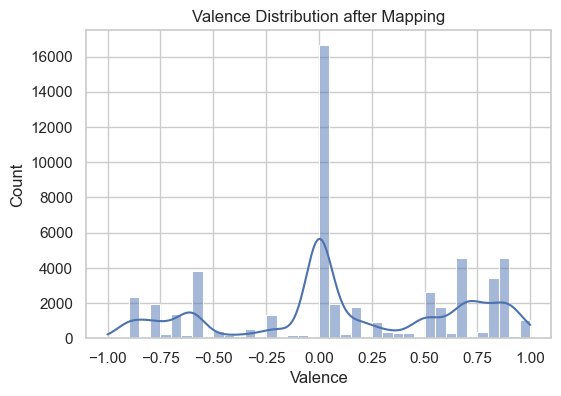

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(goemotions_df["valence"], bins=40, kde=True, ax=ax)
ax.set_title("Valence Distribution after Mapping")
ax.set_xlabel("Valence")
plt.show()



In [8]:
train_df = goemotions_df[goemotions_df["split"] == "train"].reset_index(drop=True)
val_df = goemotions_df[goemotions_df["split"].isin(["validation", "val"] )].reset_index(drop=True)
test_df = goemotions_df[goemotions_df["split"] == "test"].reset_index(drop=True)

if val_df.empty:
    train_df, val_df = train_test_split(
        train_df,
        test_size=0.15,
        random_state=RANDOM_STATE,
        shuffle=True,
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

print(f"Train size: {len(train_df):,}")
print(f"Validation size: {len(val_df):,}")
print(f"Test size: {len(test_df):,}")



Train size: 43,410
Validation size: 5,426
Test size: 5,427


In [9]:
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
EMB_DIR = DATA_DIR / "embeddings"
EMB_DIR.mkdir(parents=True, exist_ok=True)

model = SentenceTransformer(MODEL_NAME)
print(f"Loaded {MODEL_NAME} with embedding dim {model.get_sentence_embedding_dimension()}.")

def encode_with_cache(texts: List[str], cache_path: Path) -> np.ndarray:
    if cache_path.exists():
        print(f"Loading cached embeddings from {cache_path}")
        return np.load(cache_path)
    embeddings = model.encode(
        texts,
        batch_size=64,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=False,
    ).astype(np.float32)
    np.save(cache_path, embeddings)
    return embeddings

X_train = encode_with_cache(train_df["comment_text"].tolist(), EMB_DIR / "train_embeddings.npy")
X_val = encode_with_cache(val_df["comment_text"].tolist(), EMB_DIR / "val_embeddings.npy")
X_test = encode_with_cache(test_df["comment_text"].tolist(), EMB_DIR / "test_embeddings.npy")

y_train = train_df["valence"].to_numpy(dtype=np.float32)
y_val = val_df["valence"].to_numpy(dtype=np.float32)
y_test = test_df["valence"].to_numpy(dtype=np.float32)

Loaded sentence-transformers/all-mpnet-base-v2 with embedding dim 768.


Batches:   0%|          | 0/679 [00:00<?, ?it/s]

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

In [10]:
from scipy.stats import pearsonr, spearmanr

def evaluate_predictions(name: str, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    metrics = {
        "model": name,
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "r2": r2_score(y_true, y_pred),
    }
    if len(y_true) > 1:
        pearson = pearsonr(y_true, y_pred)
        spearman = spearmanr(y_true, y_pred)
        metrics["pearson_r"] = pearson.statistic
        metrics["spearman_rho"] = spearman.statistic
    return metrics

In [11]:
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("regressor", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
])

ridge_pipeline.fit(X_train, y_train)

ridge_val_raw = ridge_pipeline.predict(X_val)
ridge_val = np.tanh(ridge_val_raw)
ridge_test = np.tanh(ridge_pipeline.predict(X_test))

ridge_metrics_val = evaluate_predictions("Ridge (val)", y_val, ridge_val)
ridge_metrics_test = evaluate_predictions("Ridge (test)", y_test, ridge_test)

pd.DataFrame([ridge_metrics_val, ridge_metrics_test])

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,mae,rmse,r2,pearson_r,spearman_rho
0,Ridge (val),0.329299,0.412696,0.417802,0.651888,0.646975
1,Ridge (test),0.330421,0.413971,0.422346,0.655688,0.650667


In [12]:
pls = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pls", PLSRegression(n_components=10)),
])

pls.fit(X_train, y_train)

pls_val_raw = pls.predict(X_val).ravel()
pls_val = np.tanh(pls_val_raw)
pls_test = np.tanh(pls.predict(X_test).ravel())

pls_metrics_val = evaluate_predictions("PLS (val)", y_val, pls_val)
pls_metrics_test = evaluate_predictions("PLS (test)", y_test, pls_test)

pd.DataFrame([pls_metrics_val, pls_metrics_test])

/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,mae,rmse,r2,pearson_r,spearman_rho
0,PLS (val),0.332644,0.415643,0.409455,0.645513,0.640826
1,PLS (test),0.333201,0.417771,0.411694,0.647623,0.641770


In [13]:
from sklearn.neighbors import NearestNeighbors

K = 25
knn = NearestNeighbors(n_neighbors=K, metric="cosine", algorithm="auto")
knn.fit(X_train)

def cosine_knn_predict(X_query: np.ndarray) -> np.ndarray:
    distances, indices = knn.kneighbors(X_query, return_distance=True)
    weights = 1.0 / (distances + 1e-6)
    weights /= weights.sum(axis=1, keepdims=True)
    preds = (weights * y_train[indices]).sum(axis=1)
    return np.clip(preds, -1, 1)

knn_val = cosine_knn_predict(X_val)
knn_test = cosine_knn_predict(X_test)

knn_metrics_val = evaluate_predictions(f"Cosine kNN (k={K}) val", y_val, knn_val)
knn_metrics_test = evaluate_predictions(f"Cosine kNN (k={K}) test", y_test, knn_test)

pd.DataFrame([knn_metrics_val, knn_metrics_test])



/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,mae,rmse,r2,pearson_r,spearman_rho
0,Cosine kNN (k=25) val,0.343304,0.443582,0.327396,0.573958,0.553779
1,Cosine kNN (k=25) test,0.340890,0.443412,0.337261,0.585660,0.563337


In [14]:
calibrator = IsotonicRegression(y_min=-1.0, y_max=1.0, out_of_bounds="clip")
calibrator.fit(pls_val_raw, y_val)

pls_val_cal = calibrator.transform(pls_val_raw)
pls_test_raw = pls.predict(X_test).ravel()
pls_test_cal = calibrator.transform(pls_test_raw)

cal_metrics_val = evaluate_predictions("PLS + isotonic (val)", y_val, pls_val_cal)
cal_metrics_test = evaluate_predictions("PLS + isotonic (test)", y_test, pls_test_cal)

pd.DataFrame([cal_metrics_val, cal_metrics_test])



/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/jacksonzhao/miniconda3/envs/ollama_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,mae,rmse,r2,pearson_r,spearman_rho
0,PLS + isotonic (val),0.319259,0.409207,0.427604,0.653915,0.644624
1,PLS + isotonic (test),0.322838,0.415048,0.419336,0.647891,0.641667


In [15]:
results = pd.DataFrame([
    ridge_metrics_test,
    pls_metrics_test,
    knn_metrics_test,
    cal_metrics_test,
])
results.set_index("model")



,mae,rmse,r2,pearson_r,spearman_rho
model,,,,,
Ridge (test),0.330421,0.413971,0.422346,0.655688,0.650667
PLS (test),0.333201,0.417771,0.411694,0.647623,0.641770
Cosine kNN (k=25) test,0.340890,0.443412,0.337261,0.585660,0.563337
PLS + isotonic (test),0.322838,0.415048,0.419336,0.647891,0.641667


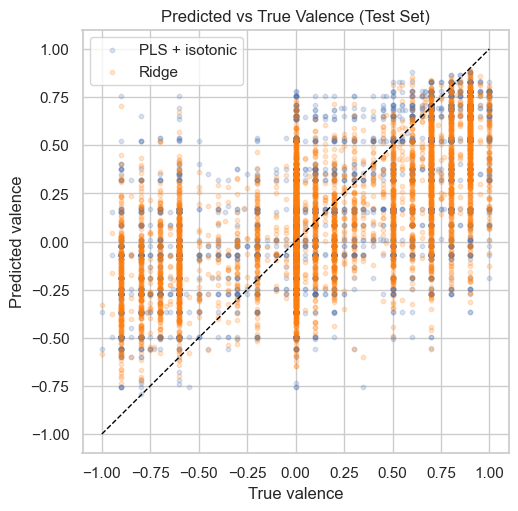

In [16]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.scatter(y_test, pls_test_cal, alpha=0.2, s=10, label="PLS + isotonic")
ax.scatter(y_test, ridge_test, alpha=0.2, s=10, label="Ridge", color="tab:orange")
ax.plot([-1, 1], [-1, 1], linestyle="--", color="black", linewidth=1)
ax.set_xlabel("True valence")
ax.set_ylabel("Predicted valence")
ax.set_title("Predicted vs True Valence (Test Set)")
ax.legend()
plt.show()



## Notes for Clinical Calibration Tweaks

- The isotonic regression layer (`calibrator`) can be re-fit on a small set of clinician-curated anchors without retraining the base PLS model.
- Temperature scaling is easy to add by wrapping raw predictions `z` with `np.tanh(z / T)`; a lower `T` sharpens the extremes while `T>1` smooths the scale.
- To inspect which labels drive extreme scores, reuse the `VALENCE_MAP` and compute `train_df.loc[idx, EMOTIONS]` for particular samples.
- Confidence intervals can be layered on top by fitting a conformal regressor or a Gaussian Process in place of Ridge/PLS.



In [17]:
results.sort_values("pearson_r", ascending=False)

,model,mae,rmse,r2,pearson_r,spearman_rho
0,Ridge (test),0.330421,0.413971,0.422346,0.655688,0.650667
3,PLS + isotonic (test),0.322838,0.415048,0.419336,0.647891,0.641667
1,PLS (test),0.333201,0.417771,0.411694,0.647623,0.641770
2,Cosine kNN (k=25) test,0.340890,0.443412,0.337261,0.585660,0.563337
